# Bundle Profile Reliablity and Streamline Alignment

<span style="color:blue">**TODO: Provide some context and description of problem**</span>

## Streamline Alignment

**Streamlines do not have the same length:**
 
- There are several approaches to align streamlines, and these choices can affect results.

  - Default is to sample uniform number of points from each streamline
  
    - While this allows for comparison across streamlines, it also will warp distance.
    
    - This could mean that if there are short and long streamlines the short streamline may align to a segment of the long streamline, but the streamline profile will not capture this.
    
**Streamlines do not necessarily begin and end in same regions**

**Streamlines may not terminate in or near gray matter**

### Methods

There are several methods for aligning streamlines to calculate bundle profiles:

- sampling/indexing (`set_number_of_points`)

  - raw average across streamlines
  
  - AFQ uses `gaussian_weights(streamlines)` (weighted averaging)

- segmentation (like `buan`)

  - BUAN approach (segmentation)

- warping

  - Warped streamlines profiles (using DTW)

    - using reference (mean, weighted average)
  
    - pairwise

We would like to compare these methods.

To determine which improves performance will look at test-retest reliabilty in HCP dataset.

## Steps

1. get HCP and HCP_retest data

2. get bundle profiles for test-retest subjects

3. cacluate test-retest reliabilty

  1. Profile reliability
  
  2. Subject reliability

4. Calculate DTW using

  1. reference streamline:
  
    - Mean
    
    - Weighted mean
  
  2. Pairwise
  
5. Once code is working port to CloudKnot (AWS)

In [1]:
import os
import os.path as op
import time

import numpy as np
import pandas as pd

from AFQ import api
import AFQ.data as afd

import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.stats.analysis import afq_profile, gaussian_weights
from dipy.tracking.streamline import set_number_of_points, values_from_volume

from fastdtw import fastdtw

import matplotlib.pyplot as plt

/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Retrieve HCP Data

In [2]:
hcp_subjects = ['103818', '105923']

In [3]:
retrieve_data = False

if retrieve_data:
    # ==== download test data ===
    afd.fetch_hcp(hcp_subjects)
    
    # ==== download retest data ===
    afd.fetch_hcp(hcp_subjects, study='HCP_Retest')

In [4]:
fetch_s3 = False

if fetch_s3:
    for subject in hcp_subjects:
        # ==== download test data ===
        subject_base_dir = op.join(afd.afq_home, 'HCP_1200', 'derivatives', 'afq', f'sub-{subject}')

        if not os.path.isdir(subject_base_dir):
            os.makedirs(subject_base_dir)
            hcp_s3_url = f's3://profile-hcp-west/hcp_reliability/single_shell/hcp_1200_afq/sub-{subject}/'
        
            !aws s3 cp {hcp_s3_url} {subject_base_dir} --recursive
        else:
            print(subject, "test data already downloaded")
        
        # ==== download retest data ===
        subject_base_dir = op.join(afd.afq_home, 'hcp_retest', 'derivatives', 'afq', f'sub-{subject}')

        if not os.path.isdir(subject_base_dir):
            os.makedirs(subject_base_dir)
            hcp_s3_url = f's3://profile-hcp-west/hcp_reliability/single_shell/hcp_retest_afq/sub-{subject}/'
        
            !aws s3 cp {hcp_s3_url} {subject_base_dir} --recursive
        else:
            print(subject, "retest data already downloaded")

## AFQ

In [5]:
def get_hcp_afq(dataset_name):
    afq = api.AFQ(
        bids_path=op.join(afd.afq_home, dataset_name),
        dmriprep='dmriprep'
    )
    
    display(afq.data_frame)
    
    return afq

hcp_test_afq = get_hcp_afq('HCP_1200')

hcp_retest_afq = get_hcp_afq('hcp_retest')

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,results_dir,gtab,dwi_affine,dwi_img
0,100307,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,103818,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,105923,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,results_dir,gtab,dwi_affine,dwi_img
0,103818,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,105923,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


### AFQ Wrappers and Data

In [6]:
bundle_names = [*hcp_retest_afq.bundle_dict]
# bundle_names = ['SLF_L', 'SLF_R'] 

In [7]:
n_points = 100

In [8]:
def get_subject_iloc(afq, subject):
    iloc = afq.data_frame.index[afq.data_frame['subject'] == subject][0]
    
    return iloc

def get_subject_scalar_data(afq, subject, scalar):
    iloc = get_subject_iloc(afq, subject)
    
    scalar_filename = afq._get_fname(
        afq.data_frame.iloc[iloc],
        f'_model-{scalar}.nii.gz'
    )

    scalar_data = nib.load(scalar_filename).get_fdata()
    
    return scalar_data

def get_subject_bundle_tractogram(afq, subject, bundle_name):
    iloc = get_subject_iloc(afq, subject)
    
    results_dir = afq.data_frame.iloc[iloc]['results_dir']
    
    fname = op.split(
        afq._get_fname(
            afq.data_frame.iloc[iloc],
            f'-{bundle_name}'
            f'_tractography.trk',
            include_track=True,
            include_seg=True
        )
    )

    tractogram_filename = op.join(results_dir, 'clean_bundles', fname[1])
    
    tractogram = load_tractogram(tractogram_filename, 'same')
    
    return tractogram

## Baseline Bundle Profiles and Correlations

test


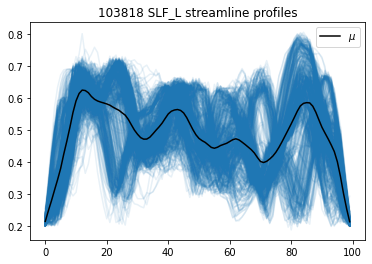

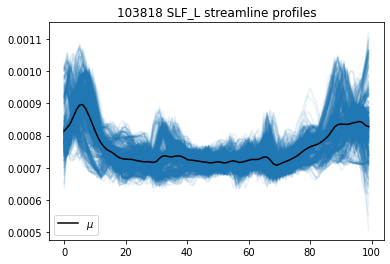

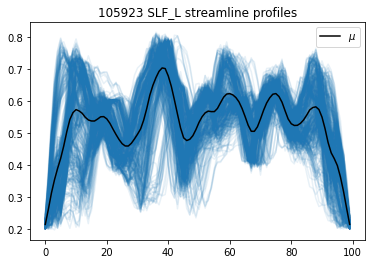

105923 ARC_R no streamlines!


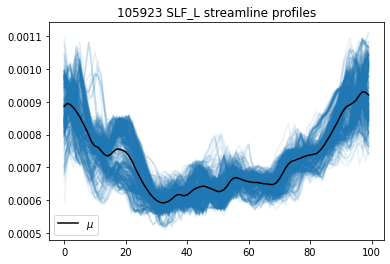

105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.2144683273120771, 0.2741186021085...","{'ATR_R': [0.21419657534304493, 0.264675593637..."
dti_md,"{'ATR_R': [0.0008419183109128342, 0.0008365659...","{'ATR_R': [0.0008736491941856806, 0.0008977903..."


retest


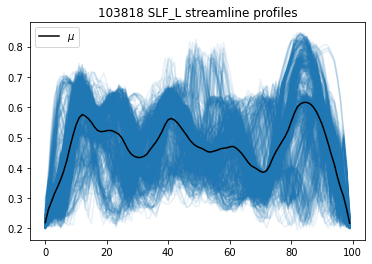

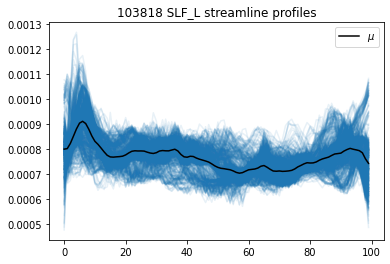

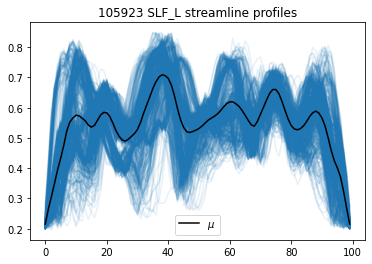

105923 ARC_R no streamlines!


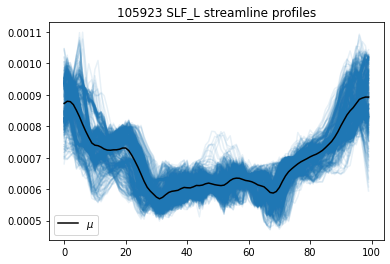

105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.21572252326657787, 0.285696309983...","{'ATR_R': [0.21579807978356796, 0.273354791867..."
dti_md,"{'ATR_R': [0.0008881062496957959, 0.0008634534...","{'ATR_R': [0.0008763236553443433, 0.0008799265..."


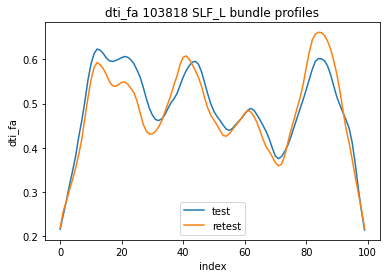

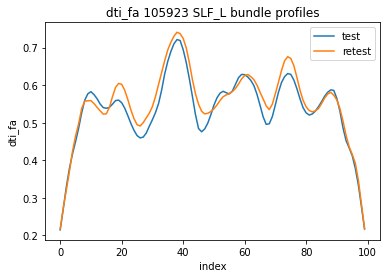

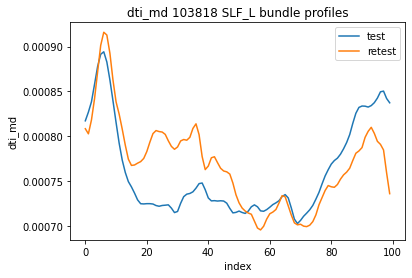

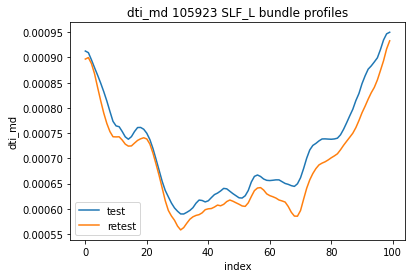

In [9]:
def get_subject_bundle_profile(afq, subject, scalar_data, bundle_name, show_streamline_profiles=False):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)

    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)
    
    if show_streamline_profiles:
        fgarray = set_number_of_points(tractogram.streamlines, n_points)
        values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
        mean_values = np.mean(values, axis=0)
        
        plt.figure()
        plt.title(f'{subject} {bundle_name} streamline profiles')
        plt.plot(values.T, c='tab:blue', alpha=0.1)
        plt.plot(mean_values.T, c='black', label='$\mu$')
        plt.legend()
        plt.show()
            
    profile = afq_profile(
        scalar_data,
        tractogram.streamlines,
        tractogram.affine,
        weights=gaussian_weights(tractogram.streamlines)
    )
    
    return profile

def get_bundle_profiles(afq):
    bundle_profiles = {}
    
    for subject in hcp_subjects:
        bundle_profiles[subject] = {}
    
        for scalar in afq.scalars:
            bundle_profiles[subject][scalar] = {}
            scalar_data = get_subject_scalar_data(afq, subject, scalar)
            
            for bundle_name in bundle_names:
                bundle_profiles[subject][scalar][bundle_name] = get_subject_bundle_profile(afq, subject, scalar_data, bundle_name, bundle_name == 'SLF_L')

    return bundle_profiles

def get_test_retest_bundle_profile_correlations(show_bundle_profile=False, show_correlations=False):
    correlations = {}

    print('test')
    test_bundle_profiles = get_bundle_profiles(hcp_test_afq)
    display(pd.DataFrame.from_dict(test_bundle_profiles))

    print('retest')
    retest_bundle_profiles = get_bundle_profiles(hcp_retest_afq)
    display(pd.DataFrame.from_dict(retest_bundle_profiles))

    for scalar in hcp_retest_afq.scalars:
        correlations[scalar] = {}
        for subject in hcp_subjects:
            correlations[scalar][subject] = {}
            for bundle_name in bundle_names:
                test_profile = test_bundle_profiles[subject][scalar][bundle_name]
                retest_profile = retest_bundle_profiles[subject][scalar][bundle_name]

                if show_bundle_profile or bundle_name == 'SLF_L':
                    plt.figure()
                    plt.title(f'{scalar} {subject} {bundle_name} bundle profiles')
                    plt.plot(test_profile, label='test')
                    plt.plot(retest_profile, label='retest')
                    plt.xlabel('index')
                    plt.ylabel(scalar)
                    plt.legend()
                    plt.show()

                test_retest_corr_matrix = pd.DataFrame(zip(*[test_profile, retest_profile]), columns=['test', 'retest']).corr()
                
                # select only the upper triangle off diagonals of the correlation matrix
                test_retest_corr = test_retest_corr_matrix.where(np.triu(np.ones(test_retest_corr_matrix.shape), 1).astype(np.bool)).stack()
                
                if show_correlations:
                    print(scalar, subject, bundle_name, 'test-retest correlation:\n', test_retest_corr)
                
                if len(test_retest_corr) == 1:
                    correlations[scalar][subject][bundle_name] = test_retest_corr[0]
                else:
                    correlations[scalar][subject][bundle_name] = 0
                
    return correlations
                
correlations = get_test_retest_bundle_profile_correlations()

### Profile reliability

,ATR_R,ATR_L,CGC_R,CGC_L,CST_R,CST_L,IFO_R,IFO_L,ILF_R,ILF_L,SLF_R,SLF_L,ARC_R,ARC_L,UNC_R,UNC_L,FA,FP
103818,0.896956,0.985442,0.973870,0.986467,0.903618,0.972804,0.966521,0.987092,0.993115,0.988466,0.982404,0.931827,0.746451,0.888864,0.967738,0.965555,0.967617,0.986897
105923,0.908311,0.961428,0.894332,0.964324,0.955317,0.939918,0.991037,0.987152,0.989472,0.950639,0.947766,0.974167,0.000000,0.979358,0.973055,0.948403,0.978733,0.972875


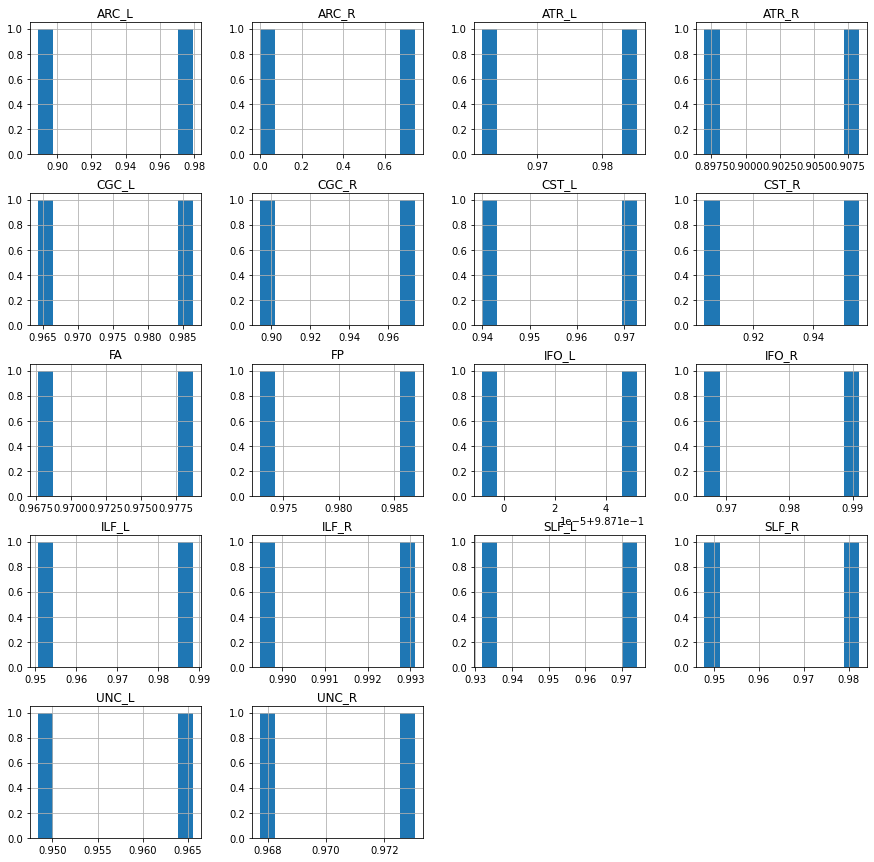

In [10]:
fa_correlations = pd.DataFrame.from_dict(correlations['dti_fa'])
display(fa_correlations.T)

ax = fa_correlations.T.hist(figsize=(15, 15))

,ATR_R,ATR_L,CGC_R,CGC_L,CST_R,CST_L,IFO_R,IFO_L,ILF_R,ILF_L,SLF_R,SLF_L,ARC_R,ARC_L,UNC_R,UNC_L,FA,FP,median
mean,0.902633,0.973435,0.934101,0.975395,0.929467,0.956361,0.978779,0.987122,0.991294,0.969552,0.965085,0.952997,0.373226,0.934111,0.970396,0.956979,0.973175,0.979886,0.967319
std,0.008030,0.016981,0.056242,0.015657,0.036557,0.023254,0.017336,0.000043,0.002576,0.026748,0.024493,0.029939,0.527821,0.063989,0.003760,0.012129,0.007860,0.009915,NaN
double_std,0.016059,0.033962,0.112484,0.031314,0.073114,0.046507,0.034671,0.000086,0.005152,0.053495,0.048985,0.059878,1.055641,0.127977,0.007520,0.024258,0.015720,0.019830,NaN


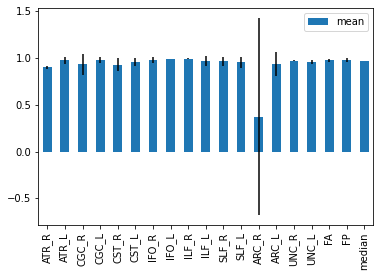

In [11]:
fa_correlations_agg = fa_correlations.agg(['mean', 'std'], axis=1)
fa_correlations_agg['double_std'] = 2 * fa_correlations_agg['std']

median = fa_correlations_agg['mean'].median(axis=0)
fa_correlations_agg = fa_correlations_agg.append(pd.Series(name='median', dtype=float))
fa_correlations_agg.at['median', 'mean'] = median
display(fa_correlations_agg.T)

ax = fa_correlations_agg.plot.bar(y='mean', yerr='double_std')

## Mean Warped Bundle Profiles and Correlations

test


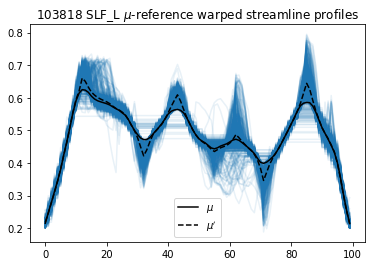

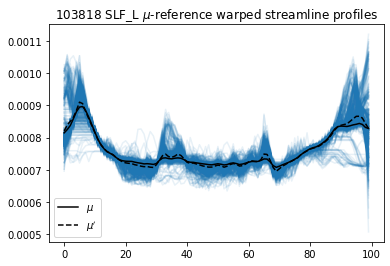

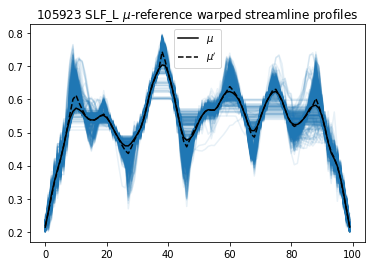

105923 ARC_R no streamlines!


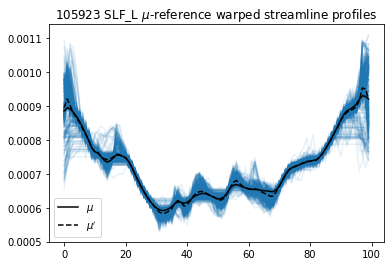

105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.2197231823765439, 0.2764624153551...","{'ATR_R': [0.21970864962713477, 0.256911889847..."
dti_md,"{'ATR_R': [0.0008486241378541823, 0.0008354188...","{'ATR_R': [0.0008753623766827375, 0.0009039141..."


retest


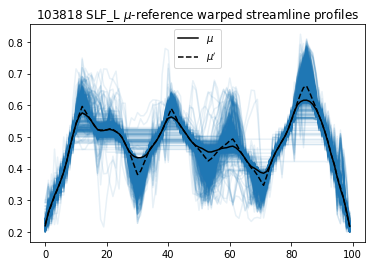

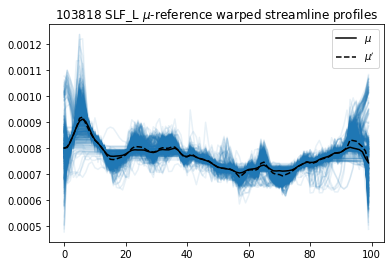

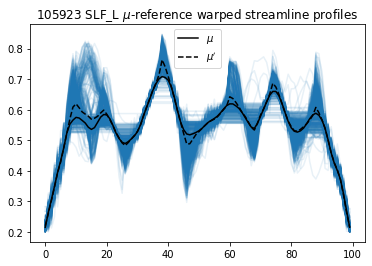

105923 ARC_R no streamlines!


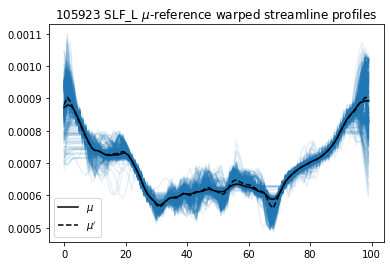

105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.22087897625706976, 0.283899992807...","{'ATR_R': [0.2250987885204518, 0.2750640156970..."
dti_md,"{'ATR_R': [0.0008597709776036279, 0.0008363742...","{'ATR_R': [0.000891702437800125, 0.00087693082..."


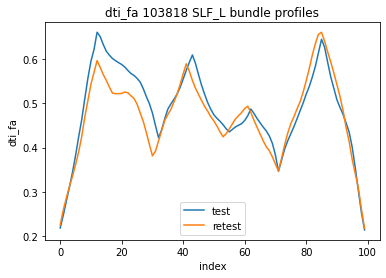

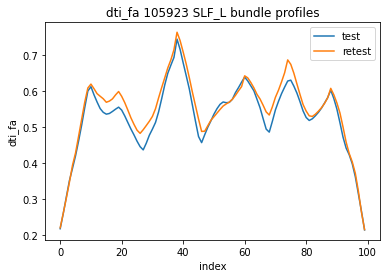

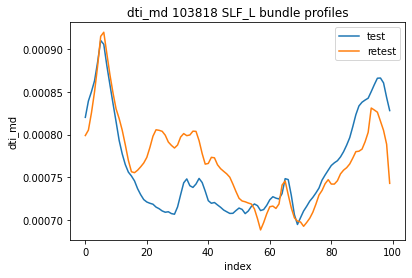

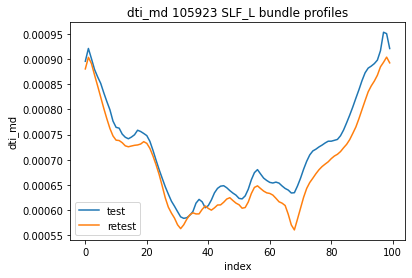

In [12]:
def get_subject_mean_warped_bundle_profile(afq, subject, scalar_data, bundle_name, show_dtw_streamline_profiles=False):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)
    
    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)
    
    fgarray = set_number_of_points(tractogram.streamlines, n_points)

    values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
    mean_values = np.mean(values, axis=0)

    tic = time.perf_counter()
    dtw_values = []

    for value in values:
        dist, path = fastdtw(value, mean_values)
        path = np.array(path)
        dtw_values.append(value[np.append(path[np.where(path[:,1][:-1] != path[:,1][1:]),0][0], len(values.T)-1)])

    dtw_values = np.array(dtw_values)
    toc = time.perf_counter()
#     print(f'dtw calculation {toc - tic:0.4f} seconds')
#     print(dtw_values.shape)

    dtw_mean_values = np.mean(dtw_values, axis=0)

    if show_dtw_streamline_profiles:
        plt.figure()
        plt.title(f'{subject} {bundle_name} $\mu$-reference warped streamline profiles')
        plt.plot(dtw_values.T, c='tab:blue', alpha=0.1)
        plt.plot(mean_values.T, c='black', label='$\mu$')
        plt.plot(dtw_mean_values.T, c='black', label='$\mu^{\prime}$', linestyle='dashed')
        plt.legend()
        plt.show()
    
    return dtw_mean_values

def get_mean_warped_bundle_profiles(afq):
    mean_warped_bundle_profiles = {}
    
    for subject in hcp_subjects:
        mean_warped_bundle_profiles[subject] = {}
        iloc = get_subject_iloc(afq, subject)

        for scalar in afq.scalars:
            mean_warped_bundle_profiles[subject][scalar] = {}
            scalar_data = get_subject_scalar_data(afq, subject, scalar)

            for bundle_name in bundle_names:
                dtw_mean_values = get_subject_mean_warped_bundle_profile(afq, subject, scalar_data, bundle_name, bundle_name == 'SLF_L')
                mean_warped_bundle_profiles[subject][scalar][bundle_name] = dtw_mean_values
                
    return mean_warped_bundle_profiles

def get_test_retest_mean_warped_bundle_profile_correlations(show_bundle_profile=False, show_correlations=False):
    correlations = {}

    print('test')
    test_bundle_profiles = get_mean_warped_bundle_profiles(hcp_test_afq)
    display(pd.DataFrame.from_dict(test_bundle_profiles))

    print('retest')
    retest_bundle_profiles = get_mean_warped_bundle_profiles(hcp_retest_afq)
    display(pd.DataFrame.from_dict(retest_bundle_profiles))

    for scalar in hcp_retest_afq.scalars:
        correlations[scalar] = {}
        for subject in hcp_subjects:
            correlations[scalar][subject] = {}
            for bundle_name in bundle_names:
                test_profile = test_bundle_profiles[subject][scalar][bundle_name]
                retest_profile = retest_bundle_profiles[subject][scalar][bundle_name]

                if show_bundle_profile or bundle_name == 'SLF_L':
                    plt.figure()
                    plt.title(f'{scalar} {subject} {bundle_name} bundle profiles')
                    plt.plot(test_profile, label='test')
                    plt.plot(retest_profile, label='retest')
                    plt.xlabel('index')
                    plt.ylabel(scalar)
                    plt.legend()
                    plt.show()

                test_retest_corr_matrix = pd.DataFrame(zip(*[test_profile, retest_profile]), columns=['test', 'retest']).corr()
                
                # select only the upper triangle off diagonals of the correlation matrix
                test_retest_corr = test_retest_corr_matrix.where(np.triu(np.ones(test_retest_corr_matrix.shape), 1).astype(np.bool)).stack()
                
                if show_correlations:
                    print(scalar, subject, bundle_name, 'test-retest correlation:\n', test_retest_corr)
                
                if len(test_retest_corr) == 1:
                    correlations[scalar][subject][bundle_name] = test_retest_corr[0]
                else:
                    correlations[scalar][subject][bundle_name] = 0
                
    return correlations
                
mean_warped_correlations = get_test_retest_mean_warped_bundle_profile_correlations()

### Mean warped profile reliability

,ATR_R,ATR_L,CGC_R,CGC_L,CST_R,CST_L,IFO_R,IFO_L,ILF_R,ILF_L,SLF_R,SLF_L,ARC_R,ARC_L,UNC_R,UNC_L,FA,FP
103818,0.821284,0.949775,0.969909,0.975958,0.913122,0.945612,0.976174,0.982396,0.982689,0.981355,0.983337,0.93000,0.68922,0.878755,0.958865,0.951385,0.939558,0.984986
105923,0.832102,0.872627,0.840958,0.940081,0.933321,0.911376,0.987077,0.976686,0.978406,0.949221,0.898359,0.98546,0.00000,0.965723,0.931948,0.967226,0.983249,0.964496


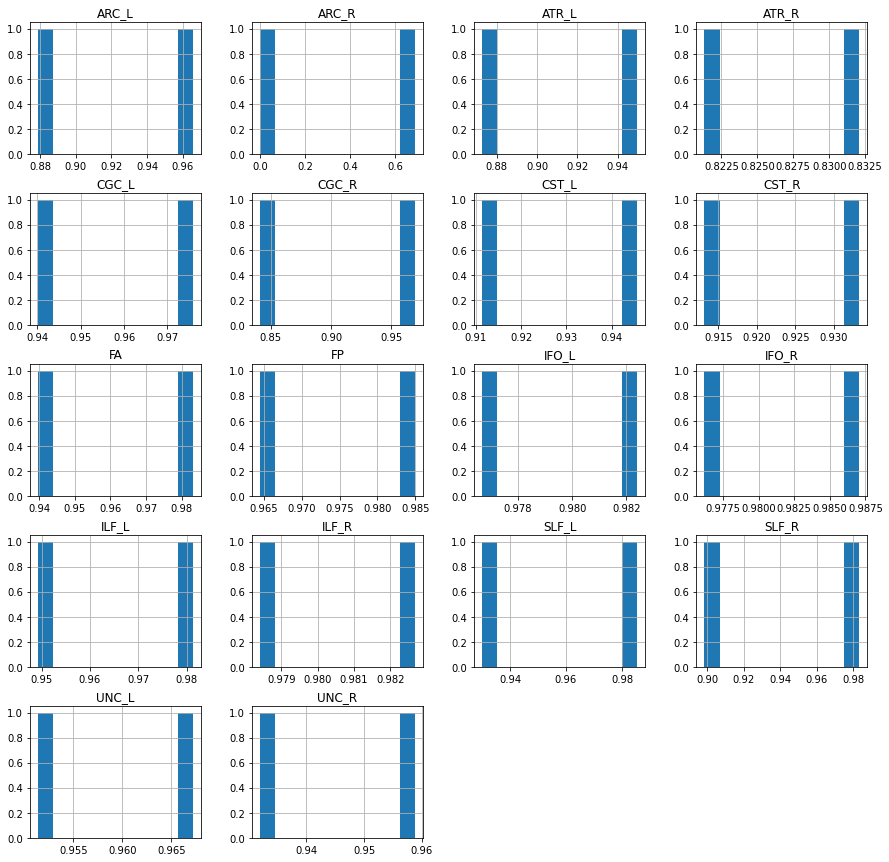

In [13]:
fa_mean_warped_correlations = pd.DataFrame.from_dict(mean_warped_correlations['dti_fa'])
display(fa_mean_warped_correlations.T)

ax = fa_mean_warped_correlations.T.hist(figsize=(15, 15))

,ATR_R,ATR_L,CGC_R,CGC_L,CST_R,CST_L,IFO_R,IFO_L,ILF_R,ILF_L,SLF_R,SLF_L,ARC_R,ARC_L,UNC_R,UNC_L,FA,FP,median
mean,0.826693,0.911201,0.905434,0.958019,0.923222,0.928494,0.981625,0.979541,0.980547,0.965288,0.940848,0.957730,0.344610,0.922239,0.945406,0.959305,0.961403,0.974741,0.951568
std,0.007650,0.054552,0.091182,0.025369,0.014283,0.024209,0.007709,0.004037,0.003028,0.022722,0.060089,0.039216,0.487352,0.061495,0.019033,0.011201,0.030894,0.014488,NaN
double_std,0.015299,0.109105,0.182364,0.050738,0.028566,0.048417,0.015418,0.008075,0.006057,0.045444,0.120177,0.078432,0.974704,0.122991,0.038067,0.022403,0.061788,0.028977,NaN


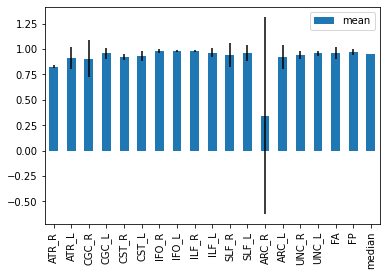

In [14]:
fa_mean_warped_correlations_agg = fa_mean_warped_correlations.agg(['mean', 'std'], axis=1)
fa_mean_warped_correlations_agg['double_std'] = 2 * fa_mean_warped_correlations_agg['std']

median = fa_mean_warped_correlations_agg['mean'].median(axis=0)
fa_mean_warped_correlations_agg = fa_mean_warped_correlations_agg.append(pd.Series(name='median', dtype=float))
fa_mean_warped_correlations_agg.at['median', 'mean'] = median
display(fa_mean_warped_correlations_agg.T)

ax = fa_mean_warped_correlations_agg.plot.bar(y='mean', yerr='double_std')

## Differences in profile reliablity

In [15]:
profile_reliability = pd.concat([fa_correlations_agg['mean'], fa_mean_warped_correlations_agg['mean'], fa_correlations_agg['mean'] - fa_mean_warped_correlations_agg['mean']], axis=1, keys=['baseline', '$\mu$ dtw', 'diff'])
display(profile_reliability.T)

,ATR_R,ATR_L,CGC_R,CGC_L,CST_R,CST_L,IFO_R,IFO_L,ILF_R,ILF_L,SLF_R,SLF_L,ARC_R,ARC_L,UNC_R,UNC_L,FA,FP,median
baseline,0.902633,0.973435,0.934101,0.975395,0.929467,0.956361,0.978779,0.987122,0.991294,0.969552,0.965085,0.952997,0.373226,0.934111,0.970396,0.956979,0.973175,0.979886,0.967319
$\mu$ dtw,0.826693,0.911201,0.905434,0.958019,0.923222,0.928494,0.981625,0.979541,0.980547,0.965288,0.940848,0.957730,0.344610,0.922239,0.945406,0.959305,0.961403,0.974741,0.951568
diff,0.075940,0.062234,0.028667,0.017376,0.006246,0.027867,-0.002846,0.007581,0.010747,0.004264,0.024237,-0.004733,0.028616,0.011872,0.024990,-0.002326,0.011771,0.005146,0.015750
